# Download and Import Libraries

In [1]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

In [3]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TextStreamer
import torch
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
model_names = [
    "johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct",
    "johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit",
    "johnjehiel/personal-health-LLM-Llama-3.2-3B-Instruct",
    "johnjehiel/personal-health-LLM-Llama-3.2-3B-Instruct-merged-4bit"
]
dataset_names = [
    "openlifescienceai/mmlu_clinical_knowledge",
    "openlifescienceai/mmlu_college_medicine",
    "openlifescienceai/mmlu_college_biology",
    "openlifescienceai/mmlu_professional_medicine",
    "openlifescienceai/mmlu_anatomy",
    "openlifescienceai/mmlu_medical_genetics",
    "openlifescienceai/pubmedqa", # different format
    "openlifescienceai/medmcqa", # different format
    "openlifescienceai/medqa"
]

# MMLU Clinical Knowledge

In [5]:
dataset_path = dataset_names[0]
dataset_name = dataset_path.split('/')[1]

In [6]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

README.md:   0%|          | 0.00/853 [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/69.2k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/6.76k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/265 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_clinical_knowledge with 265 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 265
})


In [7]:
prompt_template = """You are a medical expert specialized in {specialization}. Answer the following question by selecting the correct option (A, B, C or D) from the choices provided.

### Question:
{question}

### Options:
(A) {option_A}
(B) {option_B}
(C) {option_C}
(D) {option_D}

### Answer:
The correct answer is option ("""

EOS_TOKEN_PLACEHOLDER = "<EOS>"

In [8]:
def format_prompt(example):
    # Extract data from the 'data' dictionary.
    data = example["data"]
    question = data.get("Question", "")
    options = data.get("Options", {})
    option_A = options.get("A", "")
    option_B = options.get("B", "")
    option_C = options.get("C", "")
    option_D = options.get("D", "")
    prompt = prompt_template.format(
        specialization=example["subject_name"] if example["subject_name"] else "the entire medical field",
        question=question,
        option_A=option_A,
        option_B=option_B,
        option_C=option_C,
        option_D=option_D
    )
    return prompt

In [9]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [10]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 265 rows.


In [23]:
def evaluate_example(model, tokenizer, prompt, correct_option, max_new_tokens=4):
    EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else EOS_TOKEN_PLACEHOLDER
    full_prompt = prompt
    inputs = tokenizer([full_prompt], return_tensors="pt").to("cuda")
    
    # Optionally, use a streamer to display live output (here we omit for cleaner evaluation)
    # streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    output_ids = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    torch.cuda.synchronize()
    gen_time = time.time() - start_time
    
    generated_text = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
    
    # Simple extraction: assume the answer begins the generated text; get first character if it's A, B, C, or D.
    predicted_option = ""
    option_mp = {'1': 'A', '2':'B', '3':'C', '4':'D'}
    for char in generated_text:
        if char in ["A", "B", "C", "D"]:
            predicted_option = char
            break
        if char in ['1', '2', '3', '4']:
            predicted_option = option_mp[char]
            break
    
    # Check correctness
    is_correct = (predicted_option == correct_option)
    return generated_text, predicted_option, is_correct, gen_time

In [12]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Unsloth 2025.3.14 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Evaluating........................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Evaluating........................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-3B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/97.3M [00:00<?, ?B/s]

Unsloth 2025.3.14 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Evaluating........................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-3B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Evaluating........................................................

In [13]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_clinical_knowledge:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     59.622642   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     64.150943   
2          personal-health-LLM-Llama-3.2-3B-Instruct     85.660377   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     82.264151   

   Avg Inference Time (s)  
0                0.494502  
1                0.609394  
2                0.610680  
3                0.522158  


In [14]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_clinical_knowledge_evalutation_result.csv


In [15]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


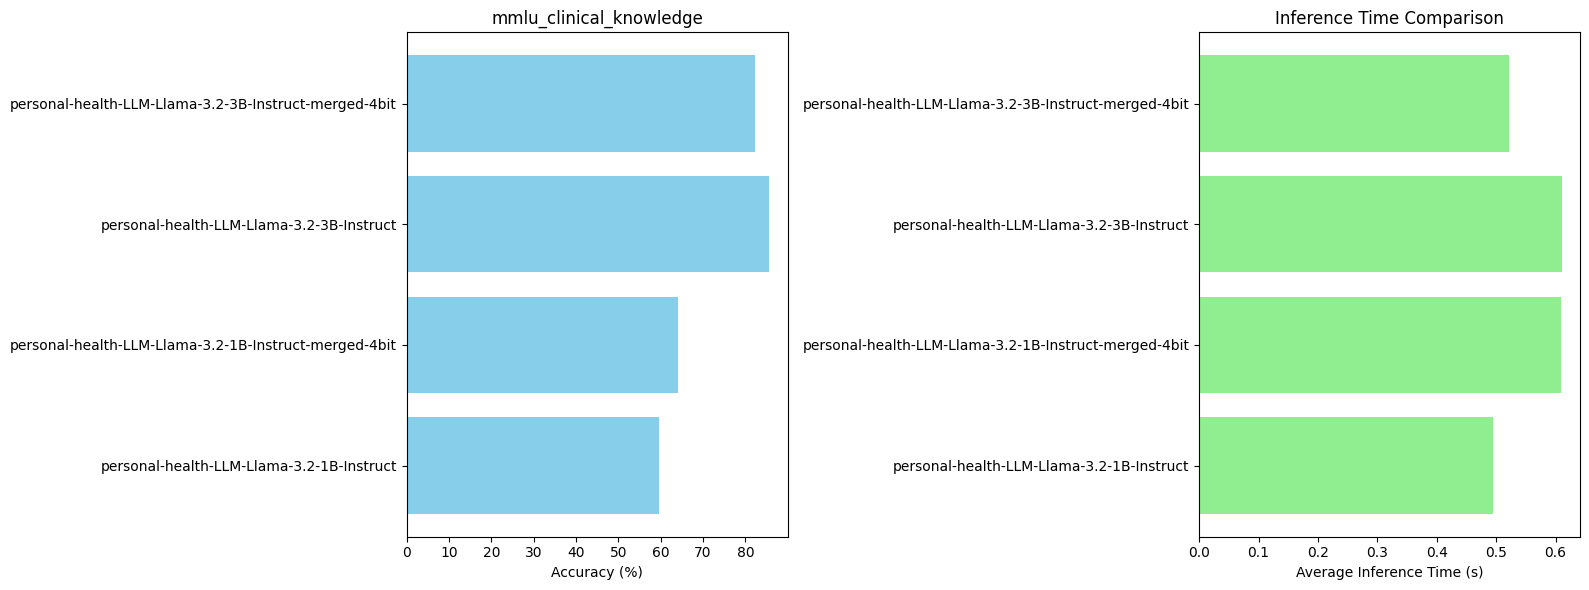

In [16]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.barh(results_df["Model"], results_df["Accuracy (%)"], color="skyblue")
plt.xlabel("Accuracy (%)")
plt.title(f"{dataset_name}")

plt.subplot(1, 2, 2)
plt.barh(results_df["Model"], results_df["Avg Inference Time (s)"], color="lightgreen")
plt.xlabel("Average Inference Time (s)")
plt.title("Inference Time Comparison")

plt.tight_layout()
plt.show()

# MMLU College Medicine

In [17]:
dataset_path = dataset_names[1]
dataset_name = dataset_path.split('/')[1]

In [18]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

README.md:   0%|          | 0.00/854 [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/63.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/8.61k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/173 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/22 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_college_medicine with 173 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 173
})


In [19]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [20]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 173 rows.


In [22]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating......................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http

In [24]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_college_medicine:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     55.491329   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     52.023121   
2          personal-health-LLM-Llama-3.2-3B-Instruct     82.658960   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     84.393064   

   Avg Inference Time (s)  
0                0.442776  
1                0.548018  
2                0.794248  
3                0.705125  


In [25]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_college_medicine_evalutation_result.csv


In [26]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


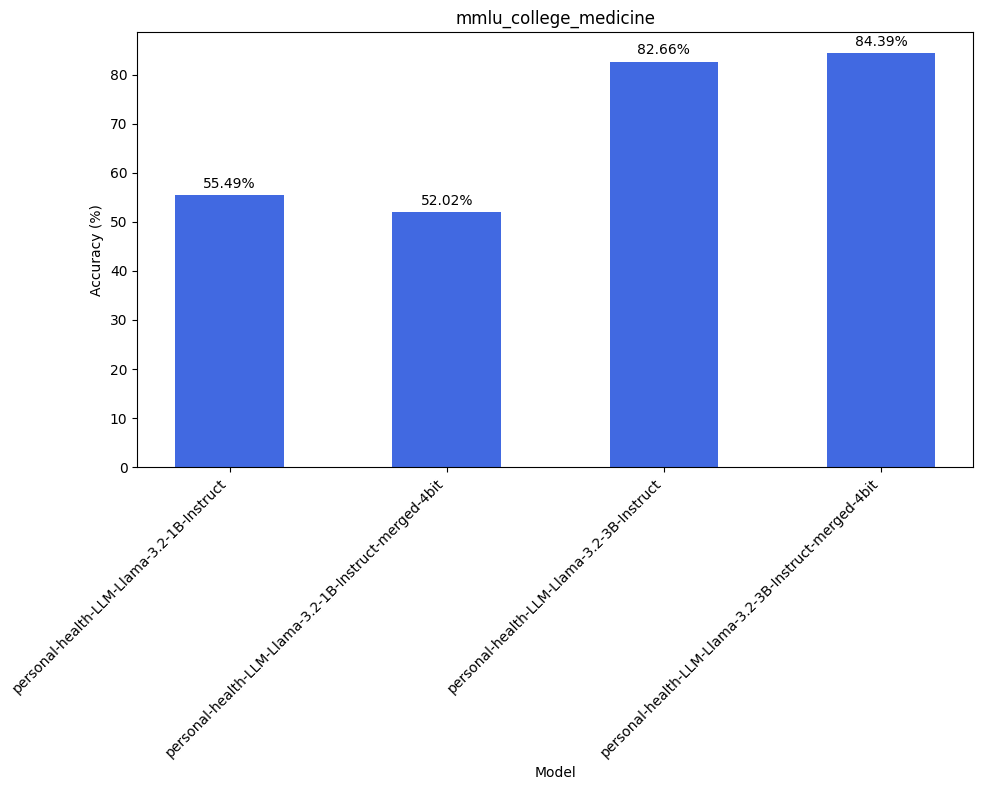

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MMLU College Biology

In [31]:
dataset_path = dataset_names[2]
dataset_name = dataset_path.split('/')[1]

In [32]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Generating test split:   0%|          | 0/144 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_college_biology with 144 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 144
})


In [33]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [34]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 144 rows.


In [35]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://git

In [36]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_college_biology:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     56.944444   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     57.638889   
2          personal-health-LLM-Llama-3.2-3B-Instruct     90.277778   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     81.250000   

   Avg Inference Time (s)  
0                0.143074  
1                0.131419  
2                0.242703  
3                0.256902  


In [37]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_college_biology_evalutation_result.csv


In [38]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


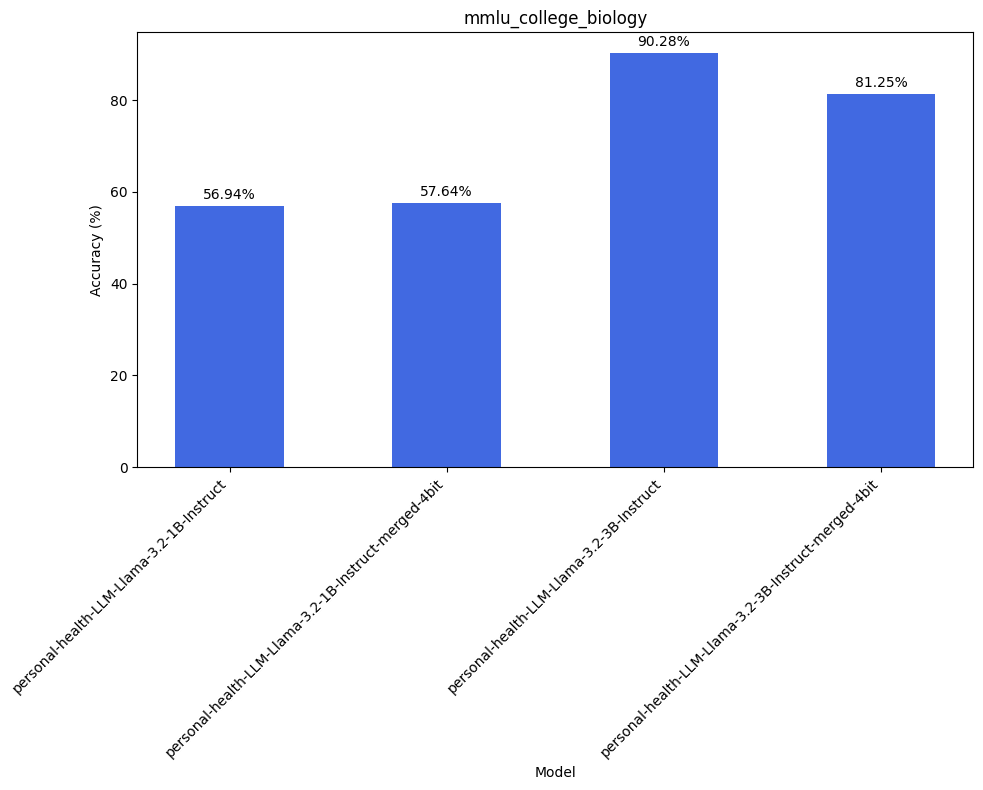

In [39]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MMLU Professional Medicine

In [40]:
dataset_path = dataset_names[3]
dataset_name = dataset_path.split('/')[1]

In [41]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Generating test split:   0%|          | 0/272 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/31 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_professional_medicine with 272 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 272
})


In [42]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [43]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 272 rows.


In [44]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating..........................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"   

In [45]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_professional_medicine:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     54.411765   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     53.676471   
2          personal-health-LLM-Llama-3.2-3B-Instruct     88.235294   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     83.455882   

   Avg Inference Time (s)  
0                0.144884  
1                0.136197  
2                0.265940  
3                0.299218  


In [46]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_professional_medicine_evalutation_result.csv


In [47]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


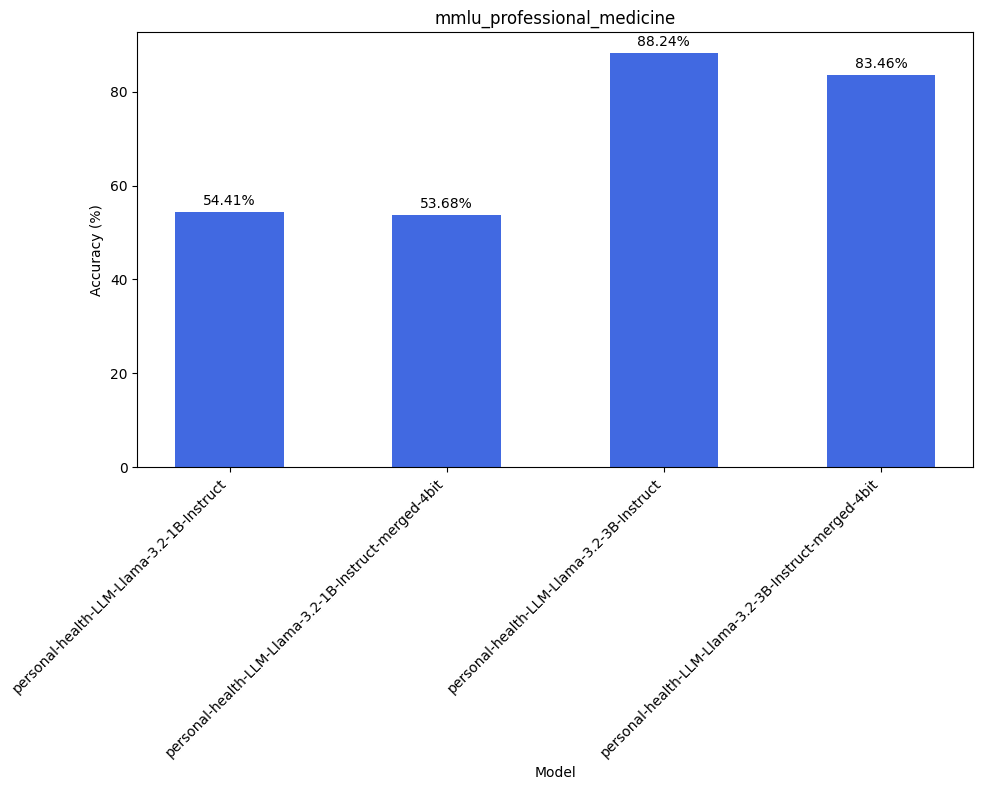

In [48]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MMLU Anatomy

In [49]:
dataset_path = dataset_names[4]
dataset_name = dataset_path.split('/')[1]

In [50]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/14 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_anatomy with 135 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 135
})


In [51]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [52]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 135 rows.


In [54]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()
print("\nEvaluation Complete !")


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating..............................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://githu

In [55]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_anatomy:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     57.037037   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     48.148148   
2          personal-health-LLM-Llama-3.2-3B-Instruct     81.481481   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     79.259259   

   Avg Inference Time (s)  
0                0.141696  
1                0.128958  
2                0.241629  
3                0.248881  


In [56]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_anatomy_evalutation_result.csv


In [57]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


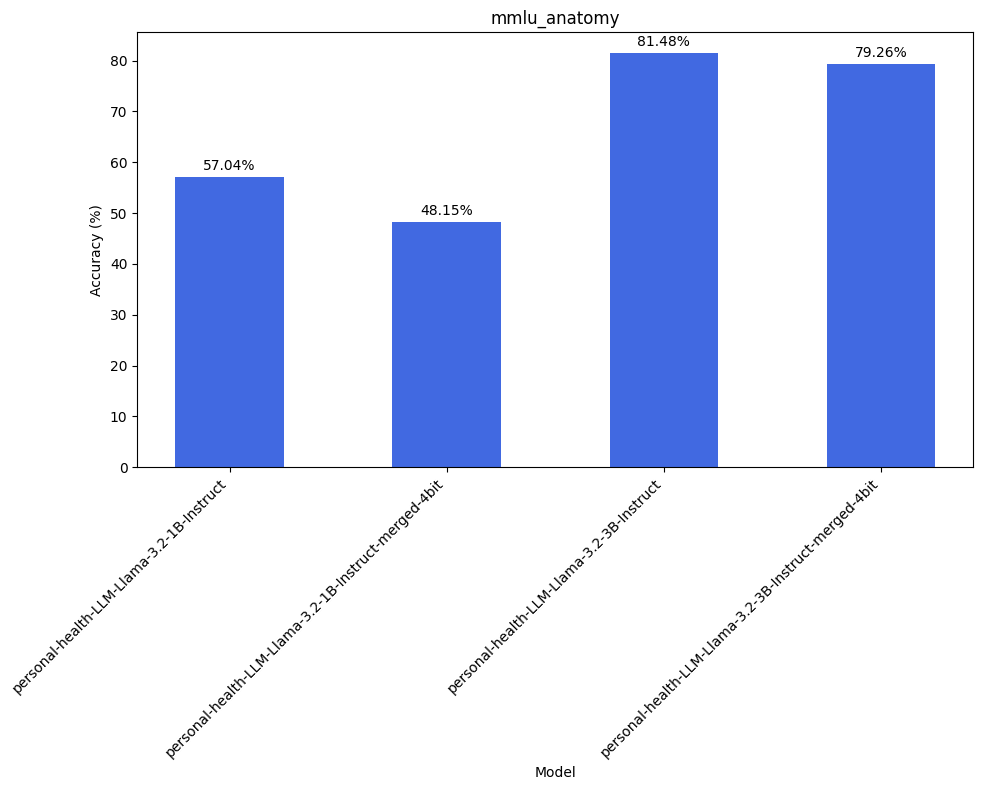

In [58]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MMLU Medical Genetics

In [59]:
dataset_path = dataset_names[5]
dataset_name = dataset_path.split('/')[1]

In [60]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded mmlu_medical_genetics with 100 examples.
Dataset({
    features: ['subject_name', 'data', 'id'],
    num_rows: 100
})


In [61]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [62]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 100 rows.


In [63]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()
print("\nEvaluation Complete !")


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating.......................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/u

In [64]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for mmlu_medical_genetics:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct          70.0   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...          62.0   
2          personal-health-LLM-Llama-3.2-3B-Instruct          89.0   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...          88.0   

   Avg Inference Time (s)  
0                0.141444  
1                0.131377  
2                0.249415  
3                0.247050  


In [65]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to mmlu_medical_genetics_evalutation_result.csv


In [66]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


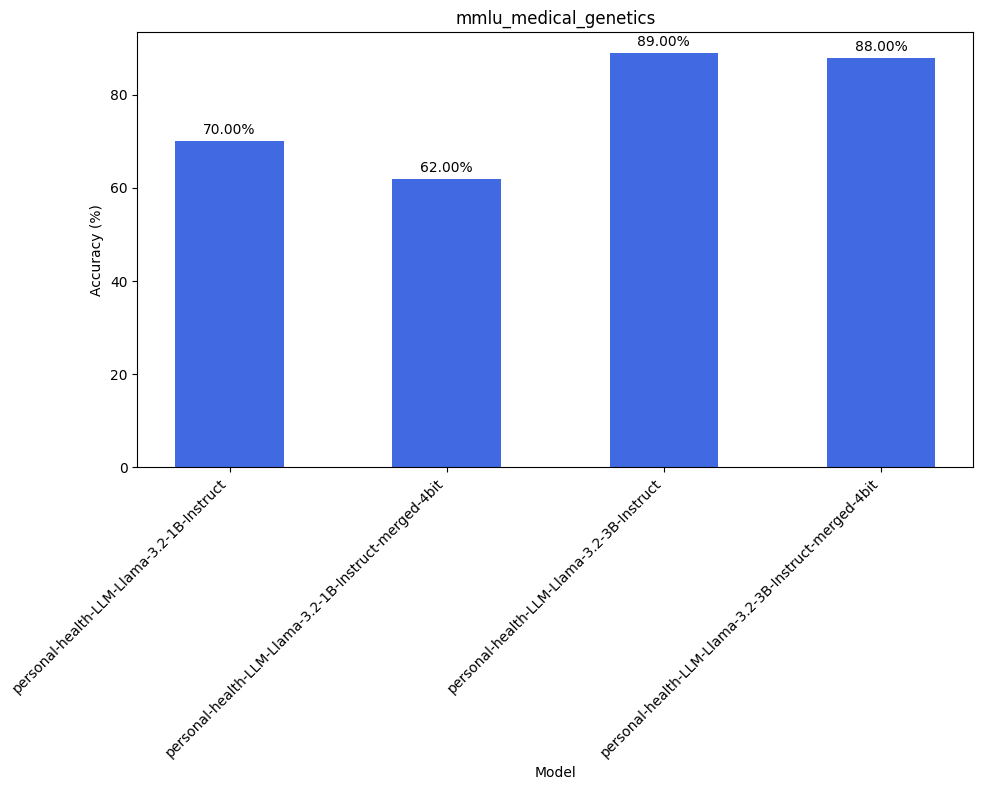

In [67]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MedQA

In [68]:
dataset_path = dataset_names[8]
dataset_name = dataset_path.split('/')[1]

In [69]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1272 [00:00<?, ? examples/s]

Loaded medqa with 1273 examples.
Dataset({
    features: ['id', 'data', 'subject_name'],
    num_rows: 1273
})


In [70]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [71]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 1273 rows.


In [72]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()
print("\nEvaluation Complete !")


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating..................................................................................................................................................................................................................................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max m

In [73]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for medqa:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     35.978005   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     36.135114   
2          personal-health-LLM-Llama-3.2-3B-Instruct     53.495679   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     51.610369   

   Avg Inference Time (s)  
0                0.144054  
1                0.134774  
2                0.269547  
3                0.311202  


In [74]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to medqa_evalutation_result.csv


In [75]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


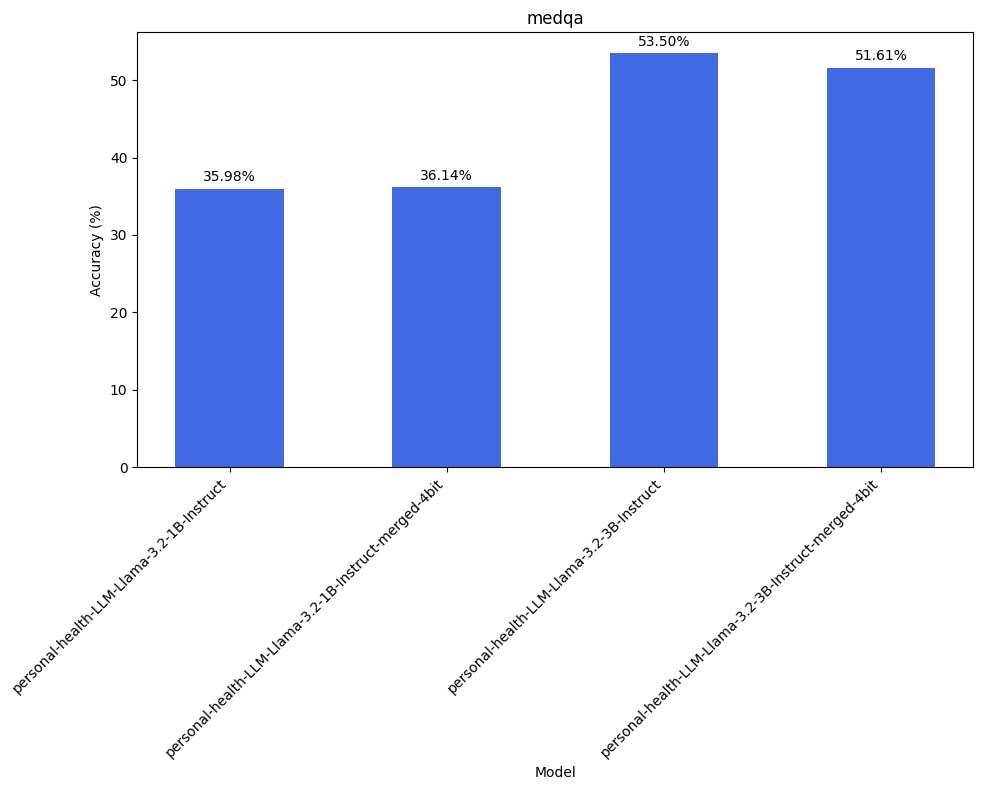

In [76]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# PubMedQA

In [91]:
dataset_path = dataset_names[6]
dataset_name = dataset_path.split('/')[1]

In [92]:
ds = load_dataset(dataset_path)["test"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Loaded pubmedqa with 500 examples.
Dataset({
    features: ['id', 'data'],
    num_rows: 500
})


In [93]:
prompt_template = """You are a medical expert specialized in bio-medical research. Analyze the given context and answer the following question by selecting the correct option (A, B or C) from the choices provided.

### Context:
{context}

### Question:
{question}

### Options:
(A) {option_A}
(B) {option_B}
(C) {option_C}

### Answer:
The correct answer is option ("""

EOS_TOKEN_PLACEHOLDER = "<EOS>"

In [94]:
def format_prompt(example):
    # Extract data from the 'data' dictionary.
    data = example["data"]
    context = data.get("Context", "")
    question = data.get("Question", "")
    options = data.get("Options", {})
    option_A = options.get("A", "")
    option_B = options.get("B", "")
    option_C = options.get("C", "")
    prompt = prompt_template.format(
        context="\n".join(context),
        question=question,
        option_A=option_A,
        option_B=option_B,
        option_C=option_C
    )
    # Append EOS token if available later.
    return prompt

In [95]:
eval_prompts = []
correct_options = []  # e.g., "A", "B", etc.
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(ex["data"].get("Correct Option", "").upper())

In [96]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 500 rows.


In [97]:
def evaluate_example(model, tokenizer, prompt, correct_option, max_new_tokens=4):
    EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else EOS_TOKEN_PLACEHOLDER
    full_prompt = prompt
    inputs = tokenizer([full_prompt], return_tensors="pt").to("cuda")
    
    # Optionally, use a streamer to display live output (here we omit for cleaner evaluation)
    # streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    output_ids = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    torch.cuda.synchronize()
    gen_time = time.time() - start_time
    
    generated_text = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
    
    # Simple extraction: assume the answer begins the generated text; get first character if it's A, B, C, or D.
    predicted_option = ""
    option_mp = {'1': 'A', '2':'B', '3':'C'}
    for char in generated_text:
        if char in ["A", "B", "C"]:
            predicted_option = char
            break
        if char in ['1', '2', '3']:
            predicted_option = option_mp[char]
            break
    
    # Check correctness
    is_correct = (predicted_option == correct_option)
    return generated_text, predicted_option, is_correct, gen_time

In [98]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating.......................................................................................................
Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct-merged-4bit
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xform

In [99]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for pubmedqa:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct          65.6   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...          68.4   
2          personal-health-LLM-Llama-3.2-3B-Instruct          73.8   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...          74.2   

   Avg Inference Time (s)  
0                0.145027  
1                0.144262  
2                0.320419  
3                0.364090  


In [100]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to pubmedqa_evalutation_result.csv


In [101]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


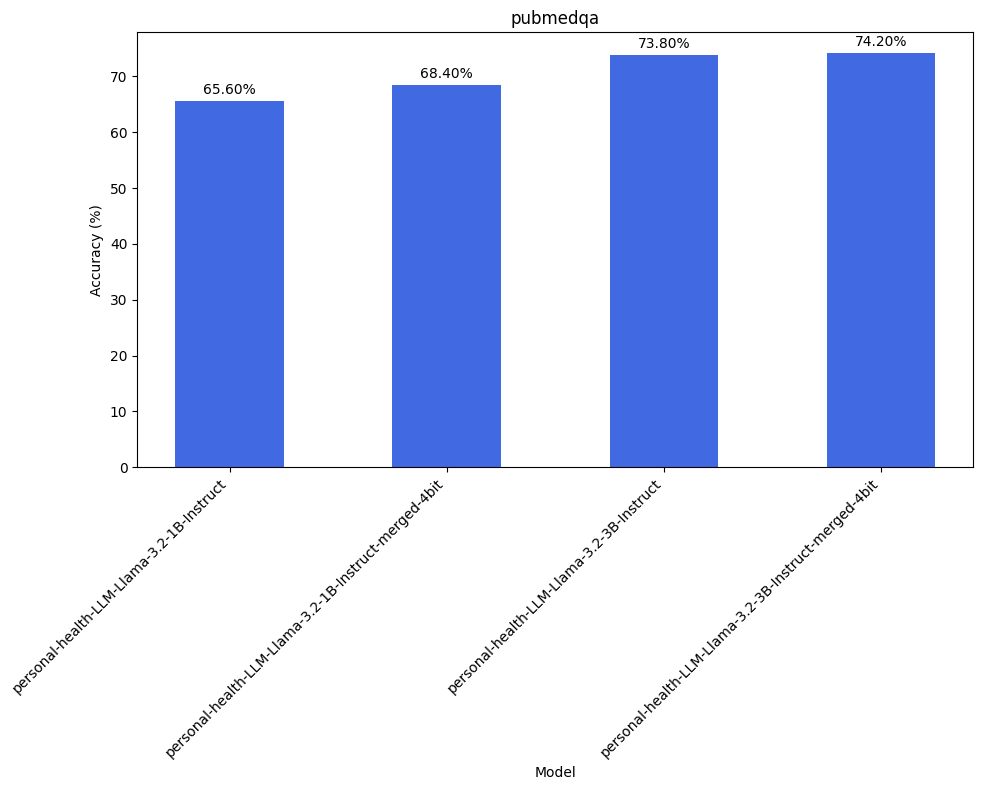

In [102]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MedMCQA

In [103]:
dataset_path = dataset_names[7]
dataset_name = dataset_path.split('/')[1]

In [104]:
ds = load_dataset(dataset_path)["validation"]
print(f"Loaded {dataset_name} with {len(ds)} examples.")
print(ds)

Loaded medmcqa with 4183 examples.
Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
    num_rows: 4183
})


In [105]:
prompt_template = """You are a medical expert on {subject_name}. Answer the following question by selecting the correct option (A, B, C or D) from the choices provided.

### Question:
{question}

### Options:
(A) {opa}
(B) {opb}
(C) {opc}
(D) {opd}

### Answer:
The correct answer is option ("""

EOS_TOKEN_PLACEHOLDER = "<EOS>"

In [106]:
def format_prompt(example):
    # Extract data from the 'data' dictionary.
    question = example["question"]
    opa = example["opa"]
    opb = example["opb"]
    opc = example["opc"]
    opd = example["opd"]
    subject_name = example['subject_name']
    prompt = prompt_template.format(
        subject_name=subject_name,
        question=question,
        opa=opa,
        opb=opb,
        opc=opc,
        opd=opd
    )
    # Append EOS token if available later.
    return prompt

In [107]:
eval_prompts = []
correct_options = []
choice_mp = {0: 'A', 1:'B', 2:'C', 3:'D'}
for ex in ds:
    eval_prompts.append(format_prompt(ex))
    # Retrieve the correct option (e.g., "Correct Option") from the data dict.
    correct_options.append(choice_mp[ex["cop"]].upper())

In [108]:
df = pd.DataFrame({
    "Prompt": eval_prompts,         # Your formatted prompts
    "Correct Option": correct_options  # The corresponding correct option for each prompt
})
print("Created DataFrame from eval_prompts and correct_options with", len(df), "rows.")

Created DataFrame from eval_prompts and correct_options with 4183 rows.


In [109]:
def evaluate_example(model, tokenizer, prompt, correct_option, max_new_tokens=4):
    EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else EOS_TOKEN_PLACEHOLDER
    full_prompt = prompt
    inputs = tokenizer([full_prompt], return_tensors="pt").to("cuda")
    
    # Optionally, use a streamer to display live output (here we omit for cleaner evaluation)
    # streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    output_ids = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    torch.cuda.synchronize()
    gen_time = time.time() - start_time
    
    generated_text = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
    
    # Simple extraction: assume the answer begins the generated text; get first character if it's A, B, C, or D.
    predicted_option = ""
    option_mp = {'1':'A', '2':'B', '3':'C', '4':'D'}
    for char in generated_text:
        if char in ["A", "B", "C", "D"]:
            predicted_option = char
            break
        if char in ['1', '2', '3', '4']:
            predicted_option = option_mp[char]
            break
    
    # Check correctness
    is_correct = (predicted_option == correct_option)
    return generated_text, predicted_option, is_correct, gen_time

In [110]:
results = []

# Iterate over each model and evaluate on the benchmark prompts.
for mname in model_names:
    print(f"\nEvaluating model: {mname}")
    # Determine quantization mode from model name.
    load_in_4bit_flag = True if "4bit" in mname.lower() else False
    
    # Load model and tokenizer using UnsLoth's API.
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=mname,
        max_seq_length=2048,
        dtype=None,
        load_in_4bit=load_in_4bit_flag,
        token=HF_TOKEN
    )
    # Set max_seq_length attribute if missing.
    model.max_seq_length = 2048
    FastLanguageModel.for_inference(model)
    
    correct_count = 0
    total_time = 0.0
    responses = []  # To store responses for analysis
    
    # Evaluate on each prompt in the benchmark subset.
    print(end="Evaluating...")
    for i, prompt in enumerate(eval_prompts):
        if i % 5 == 0: print(".", end="", flush=True)
        gen_text, pred_option, is_correct, gen_time = evaluate_example(
            model, tokenizer, prompt, correct_options[i]
        )
        responses.append(gen_text)
        total_time += gen_time
        if is_correct:
            correct_count += 1
    
    accuracy = correct_count / len(eval_prompts) * 100
    avg_time = total_time / len(eval_prompts)
    
    results.append({
        "Model": mname.split("/")[-1],
        "Accuracy (%)": accuracy,
        "Avg Inference Time (s)": avg_time
    })
    
    # Optionally, store responses in a new column for the current model.
    col_name = "Response_" + mname.split("/")[-1]
    df[col_name] = responses
    
    # Clear GPU memory before next model.
    del model, tokenizer
    torch.cuda.empty_cache()


Evaluating model: johnjehiel/personal-health-LLM-Llama-3.2-1B-Instruct
==((====))==  Unsloth 2025.3.14: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [111]:
results_df = pd.DataFrame(results)
print(f"\nEvaluation Results for {dataset_name}:")
print(results_df.head())


Evaluation Results for medmcqa:
                                               Model  Accuracy (%)  \
0          personal-health-LLM-Llama-3.2-1B-Instruct     39.038967   
1  personal-health-LLM-Llama-3.2-1B-Instruct-merg...     37.867559   
2          personal-health-LLM-Llama-3.2-3B-Instruct     50.561798   
3  personal-health-LLM-Llama-3.2-3B-Instruct-merg...     48.410232   

   Avg Inference Time (s)  
0                0.142345  
1                0.132477  
2                0.243100  
3                0.246195  


In [112]:
output_csv = f"{dataset_name}_evalutation_result.csv"
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

Results saved to medmcqa_evalutation_result.csv


In [113]:
df.to_csv(f"{dataset_name}_responses.csv", index=False)
print(f"Responses saved")

Responses saved


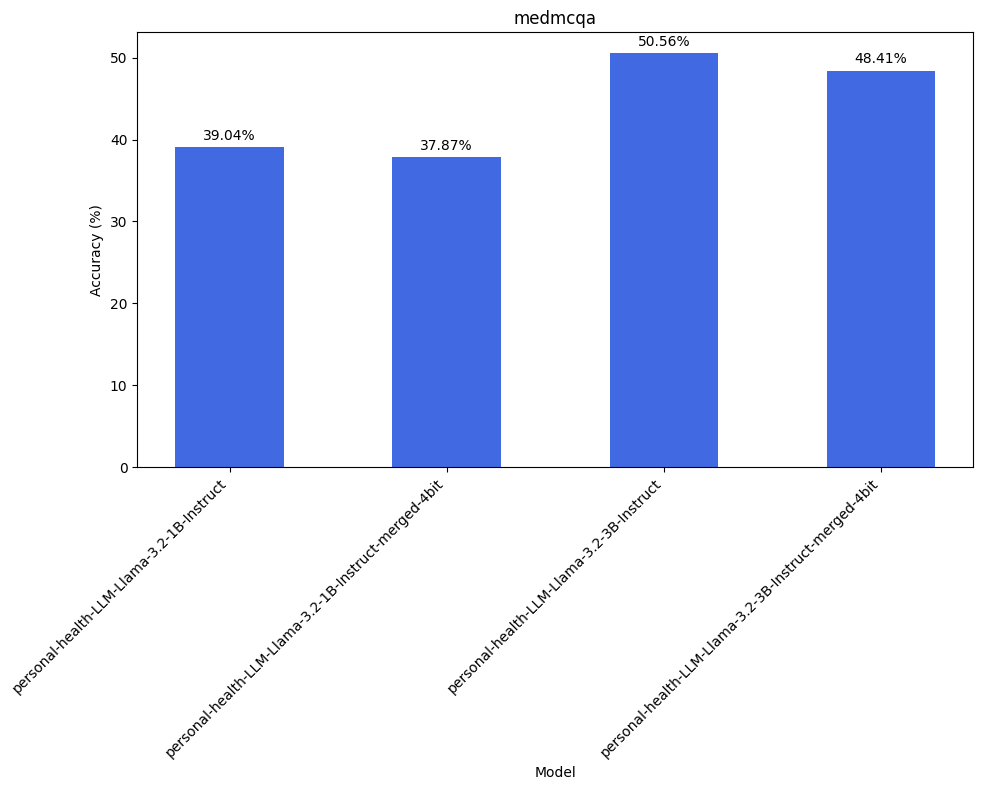

In [114]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(results_df["Model"], results_df["Accuracy (%)"], width=0.5, color="royalblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title(f"{dataset_name}")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)  # Format values with one decimal and add padding

plt.tight_layout()
plt.show()

# MultiMedQA - Average Accuracy 

In [115]:
file_paths = [
    "/kaggle/working/mmlu_clinical_knowledge_evalutation_result.csv",
    "/kaggle/working/mmlu_college_medicine_evalutation_result.csv",
    "/kaggle/working/mmlu_college_biology_evalutation_result.csv",
    "/kaggle/working/mmlu_professional_medicine_evalutation_result.csv",
    "/kaggle/working/mmlu_anatomy_evalutation_result.csv",
    "/kaggle/working/mmlu_medical_genetics_evalutation_result.csv",
    "/kaggle/working/medqa_evalutation_result.csv",
    "/kaggle/working/pubmedqa_evalutation_result.csv",
    "/kaggle/working/medmcqa_evalutation_result.csv"
]

all_data = pd.DataFrame()

for file_path in file_paths:
    df = pd.read_csv(file_path)
    all_data = pd.concat([all_data, df], ignore_index=True)

# Calculate the average accuracy for each model
average_accuracy = all_data.groupby("Model")["Accuracy (%)"].mean().reset_index()

# Save the result to a new CSV file
output_file = "/kaggle/working/MultiMedQA_average_accuracy_results.csv"
average_accuracy.to_csv(output_file, index=False)

print(f"Average accuracy across all datasets saved to {output_file}")

Average accuracy across all datasets saved to /kaggle/working/MultiMedQA_average_accuracy_results.csv


In [116]:
average_accuracy

,Model,Accuracy (%)
0,personal-health-LLM-Llama-3.2-1B-Instruct,54.902688
1,personal-health-LLM-Llama-3.2-1B-Instruct-merg...,53.337805
2,personal-health-LLM-Llama-3.2-3B-Instruct,77.241263
3,personal-health-LLM-Llama-3.2-3B-Instruct-merg...,74.760329


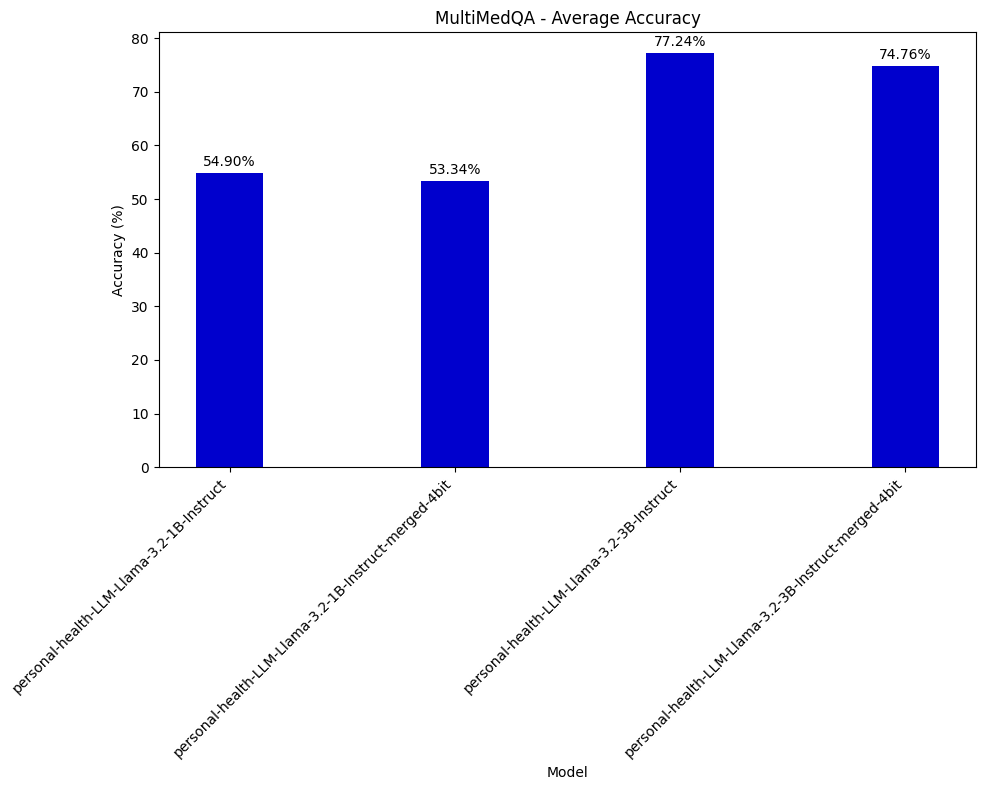

In [117]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
bars = plt.bar(average_accuracy["Model"], average_accuracy["Accuracy (%)"], width=0.3, color="mediumblue")  # Vertical bars
plt.ylabel("Accuracy (%)")  # Accuracy on y-axis
plt.xlabel("Model")         # Models on x-axis
plt.title("MultiMedQA - Average Accuracy")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

plt.bar_label(bars, fmt="%.2f%%", padding=3)

plt.tight_layout()
plt.show()